# Comparing FBA and Tnseq results

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cobra

# Functions

In [3]:
def float_convert(x):
    try:
        y = float(x)
    except:
        y = None
    return y

# Load

In [228]:
"""Tn-Seq"""
# Skip these cols
skip_cols = ['orgId', 'locusId', 'sysName', 'desc']
tnseq = pd.read_csv('ecoli_tnseq.tsv', '\t', index_col='geneName')
tnseq = tnseq[[c for c in tnseq if c not in skip_cols]]

# Metadata
md = pd.read_csv('ecoli_md.tsv', '\t')
md['Sample'] = md[['expName', 'expDesc']].apply(lambda x: ' '.join(x), 1)
md['concentration_1'] = md.concentration_1.apply(float_convert)
# md['condition'] = md[['aerobic', 'condition_1', 'condition_2']].astype(str).apply(lambda x: '_'.join(x), 1)

"""FBA results"""
# Model, for getting metabolite names
model = cobra.io.read_sbml_model('ecoli_model.xml')

fba = pd.read_csv('fba_results/ecoli_fba.csv', index_col=0)

md.head()

,orgId,expName,expDesc,timeZeroSet,num,nMapped,nPastEnd,nGenic,nUsed,gMed,...,concentration_2,condition_3,units_3,concentration_3,condition_4,units_4,concentration_4,growthPlate,growthWells,Sample
0,Keio,set10IT002,"LB, Aerobic",7/20/2015 Keio_ML9_set10,555,954600,0,658766,658236,120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"set10IT002 LB, Aerobic"
1,Keio,set10IT004,LB Aerobic with Phenazine ethosulfate 0.000062...,7/20/2015 Keio_ML9_set10,557,901412,0,630562,630227,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set10IT004 LB Aerobic with Phenazine ethosulfa...
2,Keio,set10IT005,LB Aerobic with Spiramycin 0.000125 mM,7/20/2015 Keio_ML9_set10,558,1012731,0,705994,705460,120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set10IT005 LB Aerobic with Spiramycin 0.000125 mM
3,Keio,set10IT006,LB Aerobic with Spiramycin 0.0000625 mM,7/20/2015 Keio_ML9_set10,559,1051529,0,729527,728846,130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set10IT006 LB Aerobic with Spiramycin 0.000062...
4,Keio,set10IT007,LB Aerobic with Oxytetracycline 0.00000125 mM,7/20/2015 Keio_ML9_set10,560,984917,0,733951,732897,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set10IT007 LB Aerobic with Oxytetracycline 0.0...


# Subset Tnseq to conditions in FBA simulations
And create shared condition nomenclature

In [229]:
"""Base LB media conditions"""
lb_md_idxs = md.media.eq('LB') & md.condition_1.isnull() & md.condition_2.isnull()

"""Supplemental conditions that FBA was performed in"""
# Get names of supplemental exchange reactions from FBA results
exchange_rxns = list(set([re.findall('_(EX_\w*)', c)[0] for c in fba if re.findall('_(EX_\w*)', c)]))
# Get name of supplemental media
supps_mapping = {r: model.exchanges.get_by_id(r).name.split(' exchange')[0].lower() for r in exchange_rxns}

supp_md_idxs = md.media.eq('LB') & md.condition_1.astype(str).str.lower().isin(supps_mapping.values()) | (md.condition_2.astype(str).str.lower().isin(supps_mapping.values()) & md.condition_1.isnull())

"""Combine"""
conditions_md = md[lb_md_idxs | supp_md_idxs].reset_index(drop=True)
# Add column to indicate condition name
conditions_md['condition'] = conditions_md[['condition_1', 'condition_2', 'aerobic']].fillna('').apply(lambda x: re.sub('\s+', '_', ' '.join(x).strip().lower()), 1)

"""Rename FBA conditions"""
def renameFBA(x):
    if x.endswith('_lb'):
        new = x.split('_lb')[0]
    else:
        o2 = x.split('_')[0]
        cond = supps_mapping[re.findall('\w+(EX_\w+)', x)[0]]
        new = f'{cond}_{o2}'.replace(' ', '_')
    return new
fba = fba.rename(columns=renameFBA)
fba.head()

,aerobic,chloramphenicol_aerobic,l-lysine_aerobic,dimethyl_sulfoxide_aerobic,anaerobic,chloramphenicol_anaerobic,l-lysine_anaerobic,dimethyl_sulfoxide_anaerobic
hcaB,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444
tdcC,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444
sapD,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444
ugd,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444
fpr,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444


# Compare FBA simulations with Tn-seq

In [235]:
"""Combine FBA and Tn-seq data"""
# Melt subsetted tnseq data
tnseq_sub = tnseq[conditions_md.Sample].rename_axis(index='gene', columns='Sample').stack().reset_index(name='fitness')
# Add metadata and take mean fitness for each condition
tnseq_mean_fit = tnseq_sub.merge(conditions_md[['Sample', 'condition']]).groupby(['gene', 'condition']).fitness.mean()

# Normalize FBA
fba_norm = fba / fba.loc['wildtype']
fba_melted = fba_norm.rename_axis(index='gene', columns='condition').stack().rename('fba')

# Combine
def getMedia(x):
    if (x=='aerobic') | (x=='anaerobic'):
        return 'LB'
    else:
        return x.split('_aerobic')[0].split('_anaerobic')[0]
    
combo = pd.concat([fba_melted, tnseq_mean_fit], 1, 'inner').reset_index()
combo['media'] = combo.condition.apply(getMedia)
combo['anaerobic'] = combo.condition.str.contains('anaerobic')
combo.head()

,gene,condition,fba,fitness,media,anaerobic
0,ytfE,chloramphenicol_aerobic,1.000000,-0.005333,chloramphenicol,False
1,fecD,dimethyl_sulfoxide_aerobic,1.000000,-0.029200,dimethyl_sulfoxide,False
2,tam,aerobic,1.000000,0.004500,LB,False
3,glxR,chloramphenicol_aerobic,1.000000,-0.122667,chloramphenicol,False
4,brnQ,l-lysine_aerobic,0.993989,0.104000,l-lysine,False


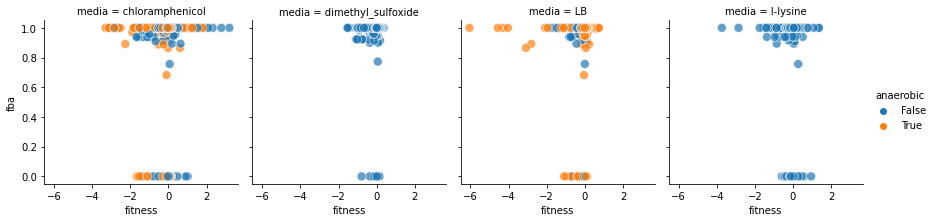

In [247]:
sns.relplot(x='fitness', y='fba', data=combo, col='media', hue='anaerobic', height=3, s=80,alpha=.7)
plt.show()